# Classification (ch. 3)
## Using the MNIST dataset

In [1]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


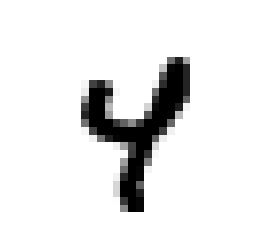

Target = 4.0  at 27507


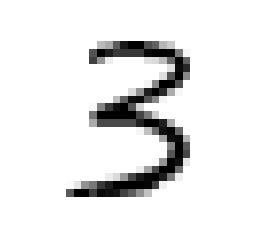

Target = 3.0  at 21644


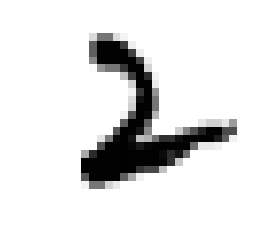

Target = 2.0  at 15230


In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from random import randint

for i in range(3):
    index = randint(0,len(X))

    some_digit = X[index]
    some_digit_image = some_digit.reshape(28, 28)

    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
               interpolation = "nearest")

    plt.axis("off")
    plt.show()
    print("Target =", y[index], " at {}".format(index))

## We need to create our test set and leave it alone until we've fully developed the model 

In [4]:
import numpy as np

shuffle_index = np.random.permutation(60000)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifier 

In [5]:
from sklearn.linear_model import SGDClassifier

index = 65996

some_digit = X[index]
some_digit_image = some_digit.reshape(28, 28)

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Measuring accuracy using cross-validation 

In [6]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.95975,  0.9441 ,  0.90615])

The previous output shows around 95% accuracy, but a model that always predicts that an image is "not 5" would reach about 90% accuracy, since about 90% of the images don't contain 5. The upshot of this is that accuracy isn't a very informative performance measure

## Confusion matrix 

In [7]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [8]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[51382,  3197],
       [  603,  4818]])

### Interpreting the matrix

<table>
    <tr><th></th><th></th><th colspan="2">Predicted</th></tr>
    <tr><td></td><td></td><td>NEG</td><td>POS</td></tr>
    <tr><th rowspan="2">Actual</th><td>NEG</td><td>54218</td><td>361</td></tr>
    <tr><td>POS</td><td>2067</td><td>3354</td><td></td></tr>
</table>


$\textrm{precision}=\frac{\textrm{true positives}}{\textrm{true positives}+\textrm{false positives}}$

$\textrm{recall}=\frac{\textrm{true positives}}{\textrm{true positives}+\textrm{false negatives}}$


In [9]:
con_mat = confusion_matrix(y_train_5, y_train_pred)

true_pos, false_pos, true_neg, false_neg = con_mat[1][1], con_mat[0][1], con_mat[0][0], con_mat[1][0]

precision = true_pos/(true_pos+false_pos)
recall = true_pos/(true_pos+false_neg)


print("Precision:", precision)
print("Recall:", recall)

Precision: 0.601122894573
Recall: 0.888765910349


In [10]:
from sklearn.metrics import precision_score, recall_score

print("Precision score:",precision_score(y_train_5, y_train_pred))
print("Recall score:", recall_score(y_train_5, y_train_pred))

Precision score: 0.601122894573
Recall score: 0.888765910349


<h1>Performance Measures</h1>
<h3>F<sub>1</sub> Score</h3>
It's convenient to combine precision and recall into a single metric called the F<sub>1</sub> score

$\textrm{precision}=\frac{\textrm{true positives}}{\textrm{true positives}+\textrm{false positives}}$

$\textrm{recall}=\frac{\textrm{true positives}}{\textrm{true positives}+\textrm{false negatives}}$

F<sub>1</sub> =$\frac{2}{\frac{1}{\textrm{precision}} + \frac{1}{\textrm{recall}}} = \frac{\textrm{true positives}}{\textrm{true positives} + \frac{\textrm{false negatives}+\textrm{false positives}}{2}}$

In [11]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7171777314676987

### Precision/Recall Tradeoff
Checkout the `SGClassifier`, which computes a score vased on a <emph>decision function</emph>. If the score is higher than a given threshold, it assigns the instance to the positive class, else negative. 

In [12]:
y_scores= sgd_clf.decision_function([some_digit])
y_scores

array([ 345906.39348982])

In [16]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
(y_some_digit_pred)


array([ True], dtype=bool)

In [18]:
threshold = 2*10**6 # ie 2000000
y_some_digit_pred = (y_scores > threshold)
(y_some_digit_pred)


array([False], dtype=bool)

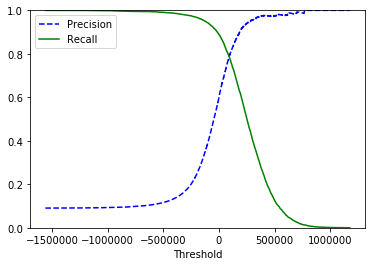

In [26]:
# deciding on the right threshold
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, figsize=(8, 6)):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.ylim([0,1])
    plt.legend(loc="upper left")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### The ROC Curve
<b>Receiver Operating Characteristic (ROC) Curve</b>: like precision/recall curve, but plots the true positive rate (TPR) against the false positive rate (FPR)

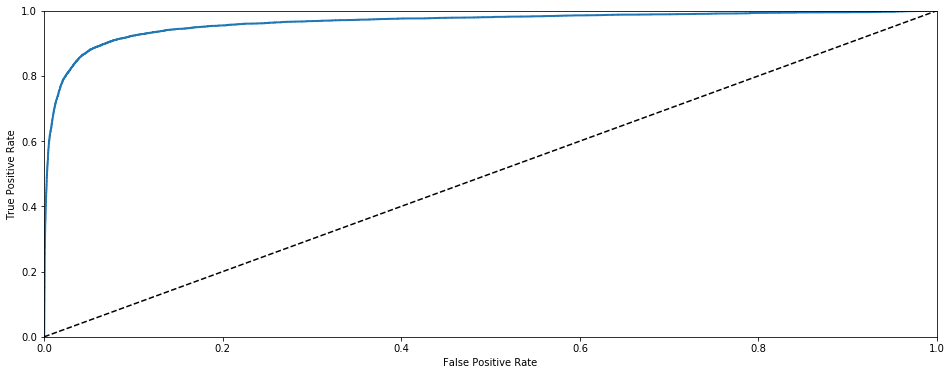

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None, figsize_=(22,10)):
    plt.figure(figsize=figsize_)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    
plot_roc_curve(fpr, tpr, figsize_=(16,6))
plt.show()

## Multiclass Classification
These are the techniques that may apply to the MTG data. You can combine multiple binary classifiers to classify data into more than two classes. There are One vs. Many and One vs. One strategies.

In [37]:
#scikit learn automatically detects when you're trying to use a binary classification alg. and used the OvA strategy

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [38]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -755049.38121292,  -524774.38768589,  -661482.1111733 ,
         -698352.60821838,  -306291.33567662,   345906.39348982,
        -1023042.63890824,  -257639.21080282,  -269003.7706112 ,
         -687265.11047479]])

In [39]:
# find the highest score...
np.argmax(some_digit_scores)

5

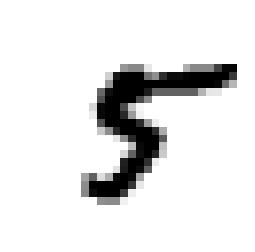

In [41]:
# hey, look! The alg. correctly classified a 5!

some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation = "nearest")

plt.axis("off")
plt.show()

In [43]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [44]:
# use OvO instead:

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [47]:
# There is one estimator for each pair of classes nCr = (10)C(2) = 45

len(ovo_clf.estimators_)

45

### Training a random forest classifier 

In [50]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])


array([ 5.])

In [51]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0. ,  0.1,  0.9,  0. ,  0. ,  0. ,  0. ]])

In [52]:
# Evaluating the classifiers

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.84513097,  0.84419221,  0.86823023])

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.84513097,  0.84419221,  0.86823023])

#### Error analysis 

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5552,    1,    6,   68,   13,   26,  101,    8,  133,   15],
       [   1, 6250,   37,   79,    6,   37,   30,   11,  261,   30],
       [  61,   43, 4517,  483,   66,   20,  215,   76,  418,   59],
       [  32,   12,   54, 5599,   12,   98,   34,   56,  159,   75],
       [  15,   19,   17,   43, 5014,   18,  108,   85,   98,  425],
       [  89,   26,   23,  585,   85, 3780,  167,   29,  483,  154],
       [  30,    8,   20,   17,   22,   51, 5679,    3,   83,    5],
       [  29,   23,   34,  311,   99,   19,    6, 5239,   37,  468],
       [  49,   84,   22,  388,   57,  167,   85,   40, 4733,  226],
       [  35,   17,   12,  220,  173,   89,    9,  538,   68, 4788]])

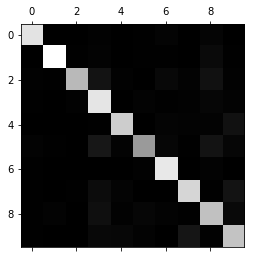

In [55]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

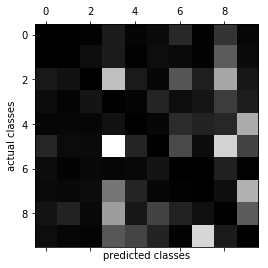

In [60]:
#  Focusing the plot on errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("predicted classes")
plt.ylabel("actual classes")
# plt.annotate("Notice the 3/5 confusion in the figure")
plt.show()

In [67]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

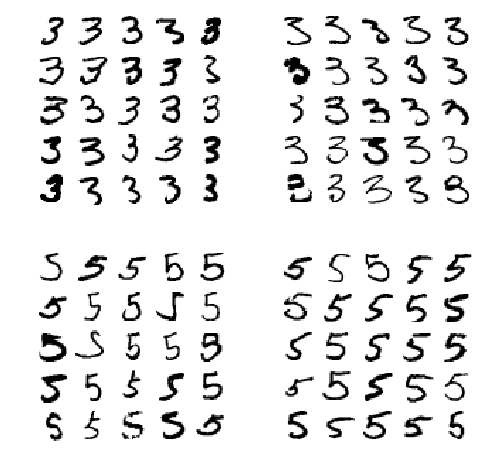

In [70]:
# Zooming in on 3/5 confusion

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # said 3 and 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # said 5 but 3
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # said 3 but 5
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # said 5 and 5

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[-25:], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[-25:], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[-25:], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[-25:], images_per_row = 5)

plt.show()